In [1]:
import numpy as np
from numba import jit, vectorize, float64, int64
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import stahmctestt as stt #our package
%matplotlib inline

## Preprocessing step adapted from 
www.kaggle.com/kost13/us-income-logistic-regression

In [2]:
#read in data 
columns = ['Age','Workclass','fnlgwt','Education','Education num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Native country','Income']
train = pd.read_csv('adult-training.csv', names=columns)
test = pd.read_csv('adult-test.csv', names=columns, skiprows=1)

In [3]:
#transform income into catagorical outcome
train['Income'] = train['Income'].apply(lambda x: 1 if x==' >50K' else 0)  ###transform income into catagorical outcome
test['Income'] = test['Income'].apply(lambda x: 1 if x==' >50K.' else 0)

In [4]:
#deal with missing data 
train.replace(' ?', np.nan, inplace=True) ###replace ? with NaN
test.replace(' ?', np.nan, inplace=True)
train=train.dropna()
train=train.drop(['Workclass','Education','Marital Status','Occupation','Relationship','Native country','Race'],axis=1)
train['Sex']=pd.factorize(train['Sex'])[0]
test=test.dropna()
test=test.drop(['Workclass','Education','Marital Status','Occupation','Relationship','Native country','Race'],axis=1)
test['Sex']=pd.factorize(test['Sex'])[0]
train.head()

,Age,fnlgwt,Education num,Sex,Capital Gain,Capital Loss,Hours/Week,Income
0,39,77516,13,0,2174,0,40,0
1,50,83311,13,0,0,0,13,0
2,38,215646,9,0,0,0,40,0
3,53,234721,7,0,0,0,40,0
4,28,338409,13,1,0,0,40,0


In [5]:
test.head()

,Age,fnlgwt,Education num,Sex,Capital Gain,Capital Loss,Hours/Week,Income
0,25,226802,7,0,0,0,40,0
1,38,89814,9,0,0,0,50,0
2,28,336951,12,0,0,0,40,1
3,44,160323,10,0,7688,0,40,1
5,34,198693,6,0,0,0,30,0


In [6]:
#devide data into predictor and outcome
ytrain = train['Income']
Xtrain = train.drop('Income', axis=1)
ytest = test['Income']
Xtest = test.drop('Income', axis=1)

In [7]:
def norma(x):
    """this is the function used to normalize continuous predictor"""
    return (x-x.mean())/x.std()

In [8]:
#normalize training
Xtrain['fnlgwt']=norma(Xtrain['fnlgwt'])
Xtrain['Capital Gain']=norma(Xtrain['Capital Gain'])
Xtrain['Capital Loss']=norma(Xtrain['Capital Loss'])
Xtrain['Age']=norma(Xtrain['Age'])
Xtrain['Education num']=norma(Xtrain['Education num'])
Xtrain['Hours/Week']=norma(Xtrain['Hours/Week'])

In [9]:
#normalize test
Xtest['fnlgwt']=norma(Xtest['fnlgwt'])
Xtest['Capital Gain']=norma(Xtest['Capital Gain'])
Xtest['Capital Loss']=norma(Xtest['Capital Loss'])
Xtest['Age']=norma(Xtest['Age'])
Xtest['Education num']=norma(Xtest['Education num'])
Xtest['Hours/Week']=norma(Xtest['Hours/Week'])

## Analysis Part

In [10]:
#define the gradient function for logistic regression
#derivation refer to hdeg.ipynb
@jit(cache=True)
def gradlogistic(theta,X,y):  
    """
    theta:p.1-1d array
    X:n.p-2d array
    y n.1-1d array"""
    drll=np.diag(y-1/(1+np.exp(-X@theta)))@X
    drpri=-np.linalg.solve(np.diag([16,16,16,16,16,16,16]),theta)
    return -drpri,-drll.mean(axis=0)

In [11]:
#the posterior sampler using sgld 
@jit([float64[:,:](float64[:,:],float64[:],float64[:],float64[:,:],float64[:,:],float64, int64,int64)],cache=True)
def sgld_nbvec(X,y,theta0,M,C,epsilon,batchsize=50,iter=1000):
    """
    This function outputs the p dimiension posterior samples with sgld algorithm.    
    Args: 
        X:n.p-2d array
        y n.1-1d array
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient of the potential
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        p: the dimension of theta
        batchsize: the number of minibatch used
        iter: iteration number, 1000 by default
    """
    n=y.size
    T=X.shape[0]
    p=theta0.shape[0]
    theta=theta0
    theta_save=np.zeros([iter,p])
    for t in range(iter):    
        batch=np.random.choice(n,batchsize,replace=False)
        pr,ll=gradlogistic(theta,X[batch,:],y[batch])
        theta=theta-(pr+T*ll)*epsilon+np.random.multivariate_normal(np.zeros(p),2*epsilon*np.identity(p),1).ravel()
        theta_save[t,:]=theta
    return theta_save

In [12]:
#the posterior sampler using sg HMC without M-H
@jit([float64[:,:](float64[:,:],float64[:],float64[:],float64[:,:],float64[:,:],float64, int64,int64)],cache=True)
def sgd_nbvec(X,y,theta0,M,C,epsilon,batchsize=50,iter=1000):
    """
    This function outputs the p dimiension stochatic gradient Hamilton Monte Carlo samples without M-H correction.    
    Args: 
        X:n.p-2d array
        y n.1-1d array
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient of the potential
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        p: the dimension of theta
        batchsize: the number of minibatch used
        iter: iteration number, 1000 by default
    """
    n=y.size
    p=theta0.shape[0]
    T=X.shape[0]
    r=np.random.multivariate_normal(np.zeros(p),M)
    theta=theta0
    theta_save=np.zeros([iter,p])
    r_save=np.zeros([iter,p])
    for t in range(iter):
        r=np.random.multivariate_normal(np.zeros(p),M)
        for i in range(1):
            mr=np.linalg.solve(M,r)
            theta=theta+epsilon*mr
            batch=np.random.choice(n,batchsize,replace=False)
            pr,ll=gradlogistic(theta,X[batch,:],y[batch])
            r=r-(pr+T*ll)*epsilon
        theta_save[t,:]=theta
        r_save[t,:]=r
    return theta_save

In [13]:
#draw from the posterior
theta0=np.zeros(7)
M=C=np.identity(7)
epsilon=.001
size=200
out_sghmc=stt.hmc_nbvec(gradlogistic,Xtrain.as_matrix(),ytrain.as_matrix(),theta0,M,C,epsilon,size,iter=5000)[:,:7]
out_sgld=sgld_nbvec(Xtrain.as_matrix(),ytrain.as_matrix(),theta0,M,C,epsilon,size,iter=5000)
out_hmcnomh=sgd_nbvec(Xtrain.as_matrix(),ytrain.as_matrix(),theta0,M,C,epsilon,size,iter=5000)

In [14]:
#use posterior predictive for prediction
def gen_testplot(out_sghmc,out_sgld,out_hmcnomh,X_test,y_test,points=[100,200,300,400,500,800,1000,1500,2000,2500,3000,3500,4500,5000]):
    """This function plots test error vs iteration number using the outputs of samplers    
    Args:
        out_sghmc: the output of SGHMC sampler
        out_sgld: the output of SGLD sampler
        X_test: the X of the test set
        y_test: the y of the test set
        points: the points to record test error
        """
    sghmcerr=[1-np.mean(np.random.binomial(n=1,p=1/(1+np.exp(-(X_test @ out_sghmc[:point,:].T))))==y_test[:,None]) for point in points]
    sglderr=[1-np.mean(np.random.binomial(n=1,p=1/(1+np.exp(-(X_test @ out_sgld[:point,:].T))))==y_test[:,None]) for point in points]
    hmcnomherr=[1-np.mean(np.random.binomial(n=1,p=1/(1+np.exp(-(X_test @ out_hmcnomh[:point,:].T))))==y_test[:,None]) for point in points]
    plt.plot(points,sghmcerr)
    plt.plot(points,sglderr)
    plt.plot(points,hmcnomherr)
    plt.legend(['sghmc','sgld','HMC without M-H'])
    plt.title('Test Error vs Iteration Number (Real Data)')
    plt.ylabel('Test Error')
    plt.xlabel('Iteration Number')
    pass

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


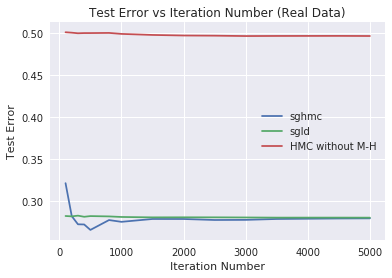

In [15]:
gen_testplot(out_sghmc,out_sgld,out_hmcnomh,Xtest.as_matrix(),ytest.as_matrix())